# Location Based Assignments

Anna Pauxberger

16 December 2018

# Principal Landmarks

For this LBA you will need to take at least 20 photos of your favorite landmark. These photos need to be as close to identical as possible, but they need to be taken during the day and over a period of at least 4 hours. Something that creates a time-lapse of your favorite landmark would be ideal, but is not necessary.

Now write code that does the following:

- processes all photos down to a size not exceeding 512 pixels in either width or height

- using principal components analysis project your images down to a 2 dimensional representation

- visually inspect the 2D locations of each photo in the new space

- show the reconstruction from each low-dimensional representation

- finally pick a point that is far away from any known location and plot its reconstruction

If you perform any other image processing steps, please clearly note them in your report. This is meant to be a reasonably light-hearted assignment, so feel free to pick irreverent landmarks or use interesting image processing techniques to find artistic reconstructions. You may also try to conduct this assignment in **three dimensions**, but no higher!

Hand in a single pdf containing all your results and a short discussion of your findings. (Make sure to include: at least 10 of your small photos and their associated reconstructions; the scatterplot of all images in the 2D space, and where your new point is; and the reconstruction from your new point.)

# My Project

This model applies PCA to reduce the dimensions of images, and reconstructs images from the reduced dimension. I chose to model my facial expression showing **happy, sad, shocked, and angry** moods. The model is able to pick up happy and angry moods, struggles to identify sad and shocked expressions however.

In [2]:
# General libraries
import numpy as np 
import pandas as pd

# Pre-Processing
from glob import glob
from PIL import Image
from resizeimage import resizeimage
from sklearn.model_selection import train_test_split

# Displaying Images
from scipy import ndimage

# SVC, PCA, LDA, Metrics
from sklearn.metrics import f1_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
%matplotlib inline

### Pre-Processing

In [88]:
def pre_processing(paths):
    original = []
    flattened = []
    for path in paths:
        with open(path, 'r+b') as f:
            with Image.open(f) as image:            
                cover = resizeimage.resize_cover(image, [100, 100])
                original.append(np.array(cover))
                flattened.append(np.array(cover).flatten())
    return original, flattened

# define path names
happy_images = glob('happy_face/*')
sad_images = glob('sad_face/*')
shocked_images = glob('shocked_face/*')
angry_images = glob('angry_face/*')

# process happy and sad images
happy = np.asarray([(i,0) for i in pre_processing(happy_images)[1]])
sad = np.asarray([(i,1) for i in pre_processing(sad_images)[1]])
shocked = np.asarray([(i,0) for i in pre_processing(shocked_images)[1]])
angry = np.asarray([(i,0) for i in pre_processing(angry_images)[1]])

X = np.concatenate((happy[:,0], sad[:,0], shocked[:,0], angry[:,0]))
Y = np.concatenate((happy[:,1], sad[:,1], shocked[:,1], angry[:,1]))

# stack to disentangle array
X = np.stack(i for i in X)
Y = np.stack(i for i in Y)

# for LDA
X = X.astype('float64')
Y = Y.astype('float64')

X.shape, Y.shape

((80, 30000), (80,))

### Perform Principal Component Analysis

The Principal Component Analysis (PCA) is an unsupervised dimensional reduction method that maximizes the variance of projected data points on the best fitted line. This is equal to minimizing the sum of the squares between the data and the line, which minimizes the error.) The more components, the more variance can be explained in a data set.

- **pca = PCA(n_components=c).fit(X)** fits a PCA with c components to the training data. The training data is specified as above, including all 80 pictures, with 20 images from each mood. I decided to imitate the changing light by changing my face, and see whether the model is able to pick up the change. 
- **components = pca.transform(X)** transforms the input vector into c components, so that each image is represented using these two components only. 
- **reconstructed = pca.inverse_transform(components)** In the reconstruction phase, the model inversed the previous transformation step, and uses the reduced PCA components as well as the eigenvectors/loadings. 

### Limitations

I only used 80 photos here, 20 per category. This is a very small data set, and in most images I look very similar. If there were more images with more variations, the reconstruction would most likely not be as accurate. 

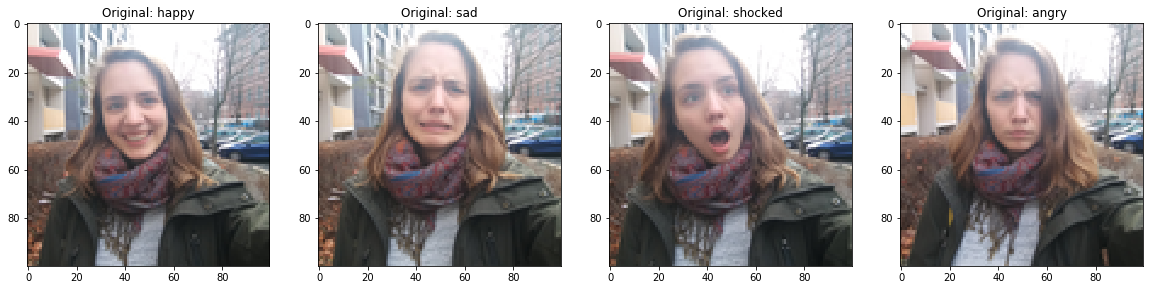

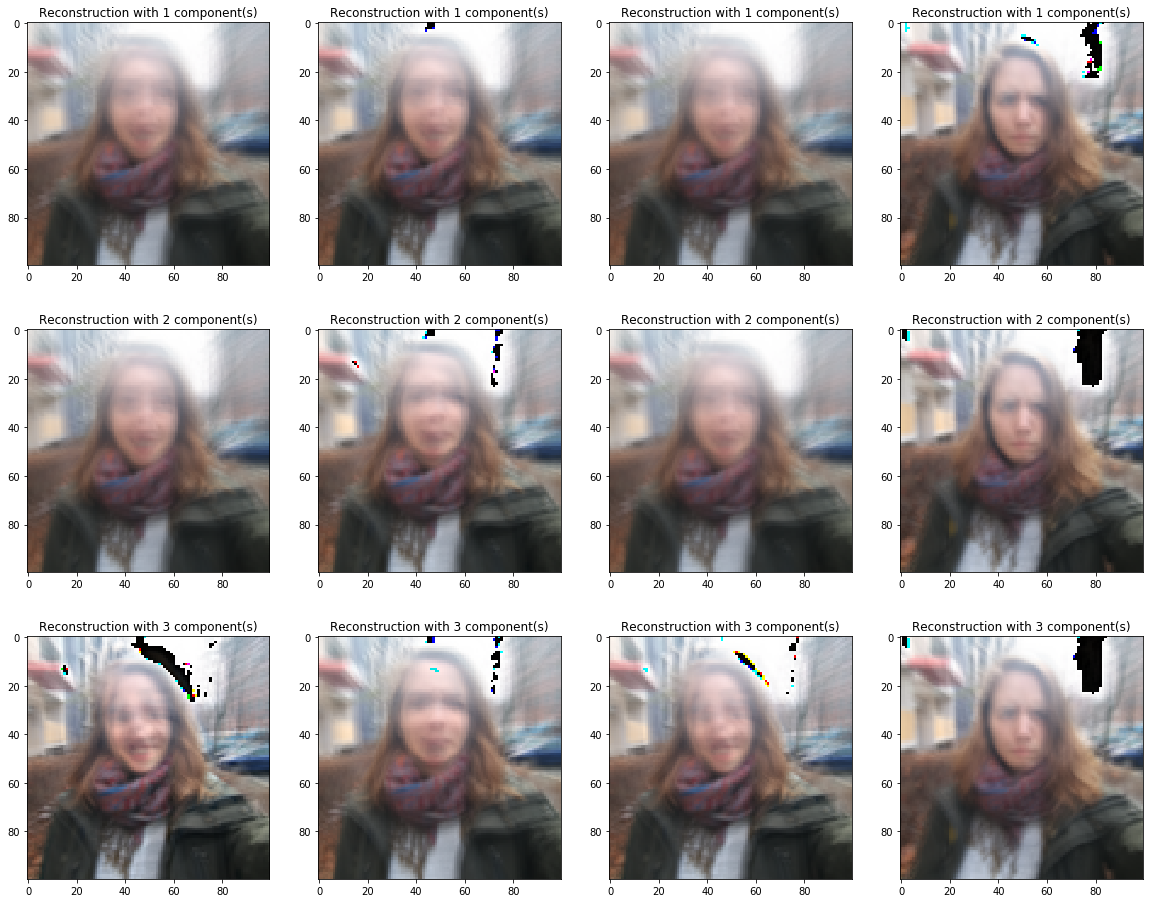

In [105]:
# Images from each mood
show_cases = [0, 20, 40, 60]
show_names = ['happy', 'sad', 'shocked', 'angry']
components = [1,2,3]
count = 1

# Show Originals
plt.figure(figsize = [20,20])
for s, n in zip(show_cases, show_names):
    plt.subplot(1,4,count)
    plt.imshow(X[s].reshape(100,100,3).astype(np.uint8))
    plt.title('Original: {}'.format(n))
    count+=1
plt.show()

# Show Reconstructions
plt.figure(figsize = [20,16])
count = 1
for c in components:
    pca = PCA(n_components=c).fit(X)
    components = pca.transform(X)
    reconstructed = pca.inverse_transform(components)

    for s, n in zip(show_cases, show_names):
        plt.subplot(3,4,count)
        plt.imshow(reconstructed[s].reshape(100,100,3).
                   astype(np.uint8))
        plt.title("Reconstruction with {} component(s)".format(c))

        count+=1
plt.show()

### Visually inspect 2D and 3D locations

From the above images we can see that while happy and angry images are more clearly reconstructed, the images for sad and shocked don't show the mood as clearly. Looking at the 2D plot, we can see that the principal components for angry (turqoise) is very distinct and far away from the other moods. Happy, sad and shocked overlap more, especially sad and shocked (blue and green) as well as happy and shocked (red and green) which also explains why the above images are less distinguishable, and why the angry reconstruction looks almost happy. The components the PCA came up with saw a lot of similarities in these pictures. 


A limitation of this training set is that I did not have access to a tripod in order to keep outside factors (e.g. how much of the sky, cars, houses etc. you can see) stable. This means that the model might have taken up irrelevant information to determine its components, such as the sky. 

In [161]:
colors = (['r' for i in range(20)]+['b' for i in range(20)]+
          ['g' for i in range(20)]+['c' for i in range(20)])
labels = ['happy', 'sad', 'shocked', 'angry']

red = happy, blue = sad, green = shocked, turqoise = angry


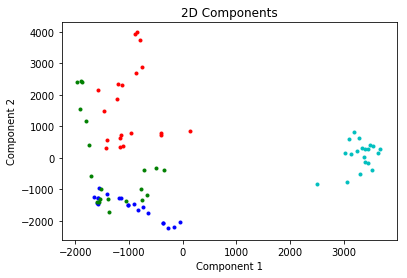

In [100]:
pca = PCA(n_components=2).fit(X)
components = pca.transform(X)

print('red = happy, blue = sad, green = shocked, turqoise = angry')

for i in range(80):
    plt.scatter(components[:,0][i], components[:,1][i], marker='.', 
                color=colors[i])
plt.title('2D Components')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

### Pick a point that is far away from any known location and plot the reconstruction

The expression is similar to a confused look, which is an interesting result given that mixed emotions often lead to a confused expression. 

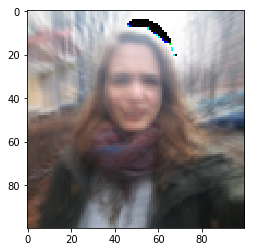

In [104]:
reconstructed = pca.inverse_transform([1500,2000])
plt.imshow(reconstructed.reshape(100,100,3).astype(np.uint8))
plt.show()

# Further Analysis

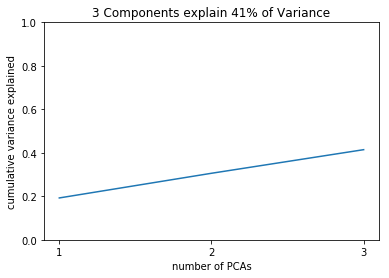

In [162]:
# Variance Explained 

variance_explained = pca.explained_variance_ratio_
cum_var_explained = np.append([None], np.cumsum(variance_explained))

plt.plot(cum_var_explained)
plt.ylabel('cumulative variance explained')
plt.xlabel('number of PCAs')
plt.ylim(0,1)
plt.xticks([1,2,3])
plt.title("3 Components explain {0:.0%} of Variance".format(
    cum_var_explained[-1]))
plt.show()

### 3D Plot

Shape: (80, 3)


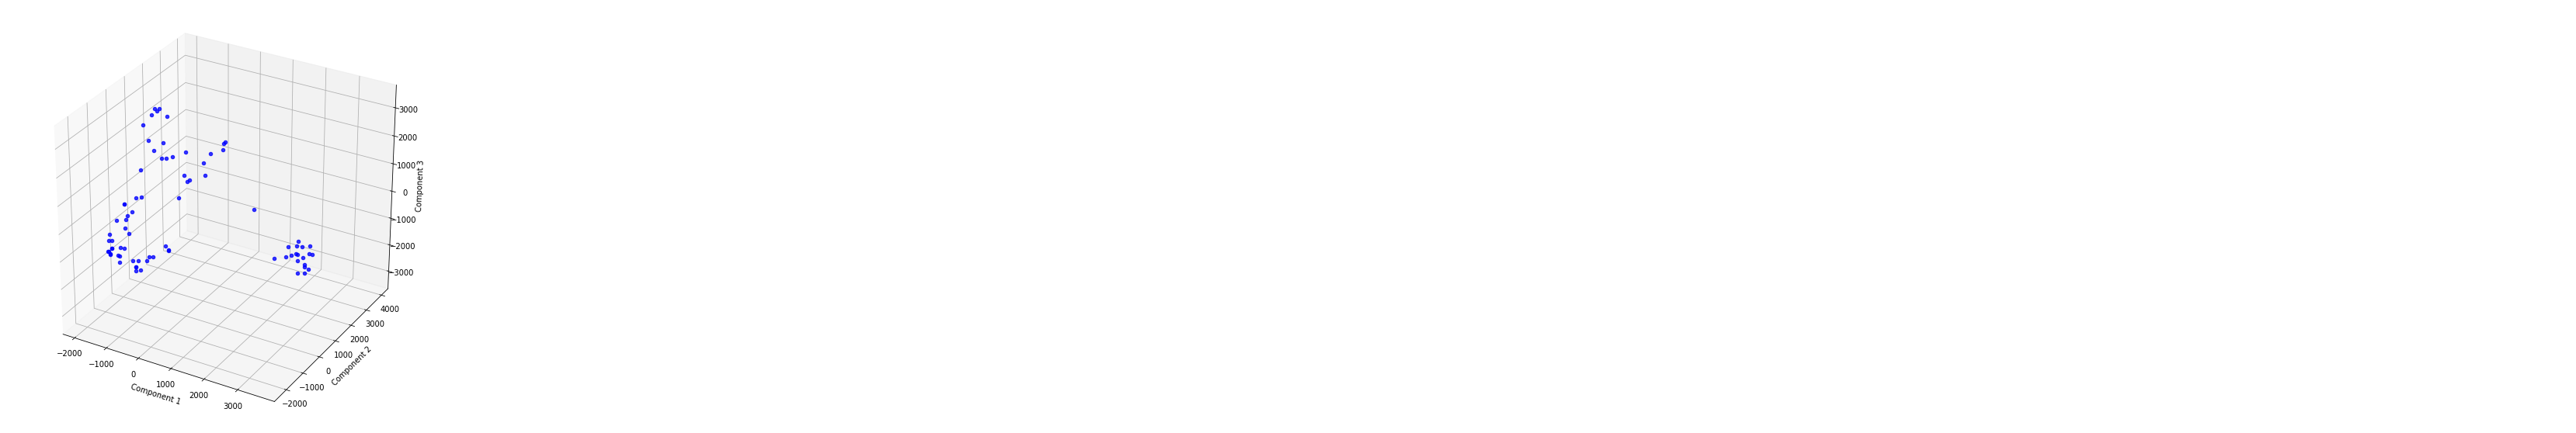

In [147]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3).fit(X)
components = pca.transform(X)
print('Shape:', components.shape)

fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(111, projection='3d')

for i in range(80):
    xs = components[i][0]
    ys = components[i][1]
    zs = components[i][2]
    ax.scatter(xs, ys, zs, c='b', alpha=0.8)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()